In [1]:
"""this note book is for analysis only, before running this notebook for analysis, we need to run the prediction  as below steps:
- You need to process 4DVarNet Mapping (using a pretrained model) using this command line !HYDRA_FULL_ERROR=1 python main.py xp=test_SCHISM in a terminal 
- You need to change the correct directory in this line of code : data4DVarnet = xr.open_dataset("outputs/2024-10-02/14-11-38/test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows/TestonOSE_DutchWaddenSea/test_data.nc")

"""



import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse.linalg as sp
import matplotlib.animation as animation
import warnings
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()

In [2]:
#to run the 4DVarNet mapping on the Gappy Satellite Observations
!HYDRA_FULL_ERROR=1 python main.py xp=test_SCHISM #this one doesn't work for me!!!, need to run this command through another terminal

Traceback (most recent call last):
  File "/home/onyxia/work/4dvarnet-starter/main.py", line 1, in <module>
    import hydra
ModuleNotFoundError: No module named 'hydra'


In [2]:
# Performance metrics (used for cross-validation in (e)DInEOF algorithms)

def rmse(x,y):
    return np.sqrt(np.mean((x-y)**2))

def RE(gt,pred):
    ep=0.0001
    return np.mean(np.abs((10**gt+ep)-(10**pred+ep))/np.abs(10**gt+ep))*100

In [3]:
# DInEOF algorithm (from https://doi.org/10.1016/j.ocemod.2004.08.001)

def DInEOF(X, mask_miss, mask_test=None, k=1, iter_=1000):
    X_rec_temp = np.zeros(X.shape)
    score = np.zeros([3,iter_])
    for i in range(iter_):
        X_rec_out = X_rec_temp.copy()
        X_rec_temp[~mask_miss] = X[~mask_miss].copy()
        #u, s, vh = sp.svds(X_rec_temp,k=k)
        #X_rec_temp = u@np.diag(s)@vh
        A = X_rec_temp.T@X_rec_temp
        p2, v = sp.eigs(A,k)
        if np.sum(np.imag(p2))!=0:
            warning.warn("Caution non-zero imaginary part has been discard")
        p = np.sqrt(np.real(p2))
        v = np.real(v)
        u = X_rec_temp@(v@np.diag(1./p))
        X_rec_temp = u@np.diag(p)@v.T
        score[0,i] = i
        score[1,i] = k
        score[2,i] = rmse(X[mask_test], X_rec_temp[mask_test])
        if i>0:
            if score[2,i]>score[2,i-1]:
                score = score[:,0:i+1]
                return X_rec_out, score
            elif np.abs(score[2,i]-score[2,i-1])<1.e-4:
                k+=1
    X_rec_out = X_rec_temp
    return X_rec_out, score

In [4]:
# eDInEOF algorithm (from https://doi.org/10.5194/os-5-475-2009)

def eDInEOF(X, mask_miss, mask_test, dt=1, alpha=1.e-2 , s_=5, k=1, iter_=1000):
    N = X.shape[1]
    F = -2*np.eye(N,N)+np.eye(N,N,-1)+np.eye(N,N,1)
    F[1,0] = 2
    F[-2,-1] = 2
    F = (alpha/dt**2)*F
    
    X_rec_temp = np.zeros(X.shape)
    score = np.zeros([3,iter_])    
    for i in range(iter_):
        X_rec_out = X_rec_temp.copy()
        X_rec_temp[~mask_miss] = X[~mask_miss].copy()
        for s in range(s_):
            X_rec_temp = X_rec_temp+X_rec_temp@F
        #u, sigma, vh = sp.svds(X_rec_temp, k=k)
        #X_rec_temp = u@np.diag(sigma)@vh
        A = X_rec_temp.T@X_rec_temp
        p2, v = sp.eigs(A,k)
        if np.sum(np.imag(p2))!=0:
            warning.warn("Caution non-zero imaginary part has been discard")
        p = np.sqrt(np.real(p2))
        v = np.real(v)
        u = X_rec_temp@(v@np.diag(1./p))
        X_rec_temp = u@np.diag(p)@v.T
        score[0,i] = i
        score[1,i] = k
        score[2,i] = rmse(X[mask_test], X_rec_temp[mask_test])
        if i>0:
            if score[2,i]>score[2,i-1]:
                score = score[:,0:i+1]
                return X_rec_out, score
            elif np.abs(score[2,i]-score[2,i-1])<1.e-4:
                k+=1
    X_rec_out = X_rec_temp
    return X_rec_out, score

In [8]:

import os
os.getcwd()

'/home/onyxia/work/4dvarnet-starter'

In [26]:
#This cell is to prepare for computing DInEOF and eDInEOF
var = 'SPM'

start_date='2020-06-01'
end_date='2020-06-26'

#OSE
data = xr.open_dataset('data/Obs_SPM_log10_aNam_removed_50percent_patch_again.nc').sel(time=slice(start_date,end_date)) #Gappy observations
#data_GT = xr.open_dataset('./data/DATA_aNam/Obs_SPM_log10_aNam.nc').sel(time=slice('2020-01-01','2020-11-26')) 
land_mask = xr.open_dataset('data/land_mask_OSE.nc')


nlat = data.lat.size
nlon = data.lon.size

nb_sea_pix = np.sum(np.isnan(land_mask.mask.values)) # Nb of sea pixels to be filled
idx_sea = np.isnan(land_mask.mask.values.flatten()) # Sea pixels locations

dt = len(data.time) # Length of the time-serie
X = np.full([nb_sea_pix,dt],np.nan) # Init. of the matrix to store vectorized sea-pixels

# Loop to build the data matrix to be used in completion algorithms
for t in range(dt):
    data_t = data[var][t].values.flatten()
    X[:,t] = data_t[idx_sea]
    
mask_mv = np.isnan(X) # Missing data mask matrix
mask_data = 1-mask_mv # Data mask matrix
data_index = np.where(mask_data) # Data index

mask_crossval = np.full([nb_sea_pix,dt], False, dtype=bool) # Init. mask matrix for cross-validation data
rand_pick = np.random.permutation(data_index[0].size)[0:int(.01*data_index[0].size)]
data_pick = (data_index[0][rand_pick],data_index[1][rand_pick]) # Random selection of data for cros-validation (1%)
mask_crossval[data_pick] = True

mask_mv[mask_crossval] = True

# Data normalization
mu = np.nanmean(X)
std = np.nanstd(X)**2
X = (X-mu)/std
X = np.where(np.isnan(X),0,X)

In [27]:
# DInEOF completion, takes around 2 minutes 47 seconds for 1 year of test data (the whole year 2018)
X_rec, score = DInEOF(X, mask_mv, mask_crossval)
X_rec = X_rec*std+mu

# Reshaping
rec_DInEOF = np.zeros([dt,nlat,nlon])
for t in range(dt):
    data_t = np.full([nlat*nlon], np.nan)
    data_t[idx_sea] = X_rec[:,t]
    rec_DInEOF[t] = data_t.reshape(nlat,nlon)

#saving reconstruction    
rec_DInEOF = xr.DataArray(rec_DInEOF,name=var,coords=[data.time[0:dt],data.lat,data.lon],dims=['time','lat','lon'])

#OSE
rec_DInEOF.to_netcdf('data/DInEOF_log10.nc')

In [29]:
# compute score (RMSE, RE) of all algorithms

# #load data OSE
rec_DInEOF = xr.open_dataset('data/DInEOF_log10.nc')#.sel(time="2018")

data4DVarnet = xr.open_dataset("outputs/2024-10-02/14-11-38/test_SCHISM_AugPatches_BiggerModel_smallerTimeWindows/TestonOSE_DutchWaddenSea/test_data.nc")

GT = xr.open_dataset('data/Obs_SPM_log10_aNam.nc').sel(time=slice(start_date,end_date))
Obs = xr.open_dataset('data/Obs_SPM_log10_aNam_removed_50percent_patch_again.nc').sel(time=slice(start_date,end_date))



#declare the pixels in which we process RMSE and RE
mask_obs_minus_GT = ~np.isnan(GT.SPM.values) & np.isnan(Obs.SPM)#mask_obs_minus_GT = True if Obs is nan and GT is not nan (and False otherwise)

#score_DInEOF 
score_DInEOF = rmse(GT.SPM.values[mask_obs_minus_GT],rec_DInEOF.SPM.values[mask_obs_minus_GT])
print("RMSE DinEOF: ",score_DInEOF)

#RE_DInEOF
RE_DInEOF = RE(GT.SPM.values[mask_obs_minus_GT],rec_DInEOF.SPM.values[mask_obs_minus_GT])
print("RE DinEOF: ", RE_DInEOF)



#score_4DVarNet
score_4DVarNet = rmse(GT.SPM.values[mask_obs_minus_GT],data4DVarnet.out.values[mask_obs_minus_GT])
print("RMSE 4DVarNEt: ",score_4DVarNet)

#RE_4DVarNet
RE_4DVarNet = RE(data4DVarnet.tgt.values[mask_obs_minus_GT],data4DVarnet.out.values[mask_obs_minus_GT])
print("RE 4DVarNEt: ",RE_4DVarNet)


RMSE DinEOF:  0.29873422047700643
RE DinEOF:  58.91682454568471
RMSE 4DVarNEt:  0.19490776691950043
RE 4DVarNEt:  37.34821179709244


In [30]:
#OSE
land_mask=xr.open_dataset('data/land_mask_OSE.nc')
GT = xr.open_dataset('data/Obs_SPM_log10_aNam.nc')#.sel(time="2018")

##OSSE
# land_mask=xr.open_dataset('./data/land_mask_SCHISM_Nga.nc')

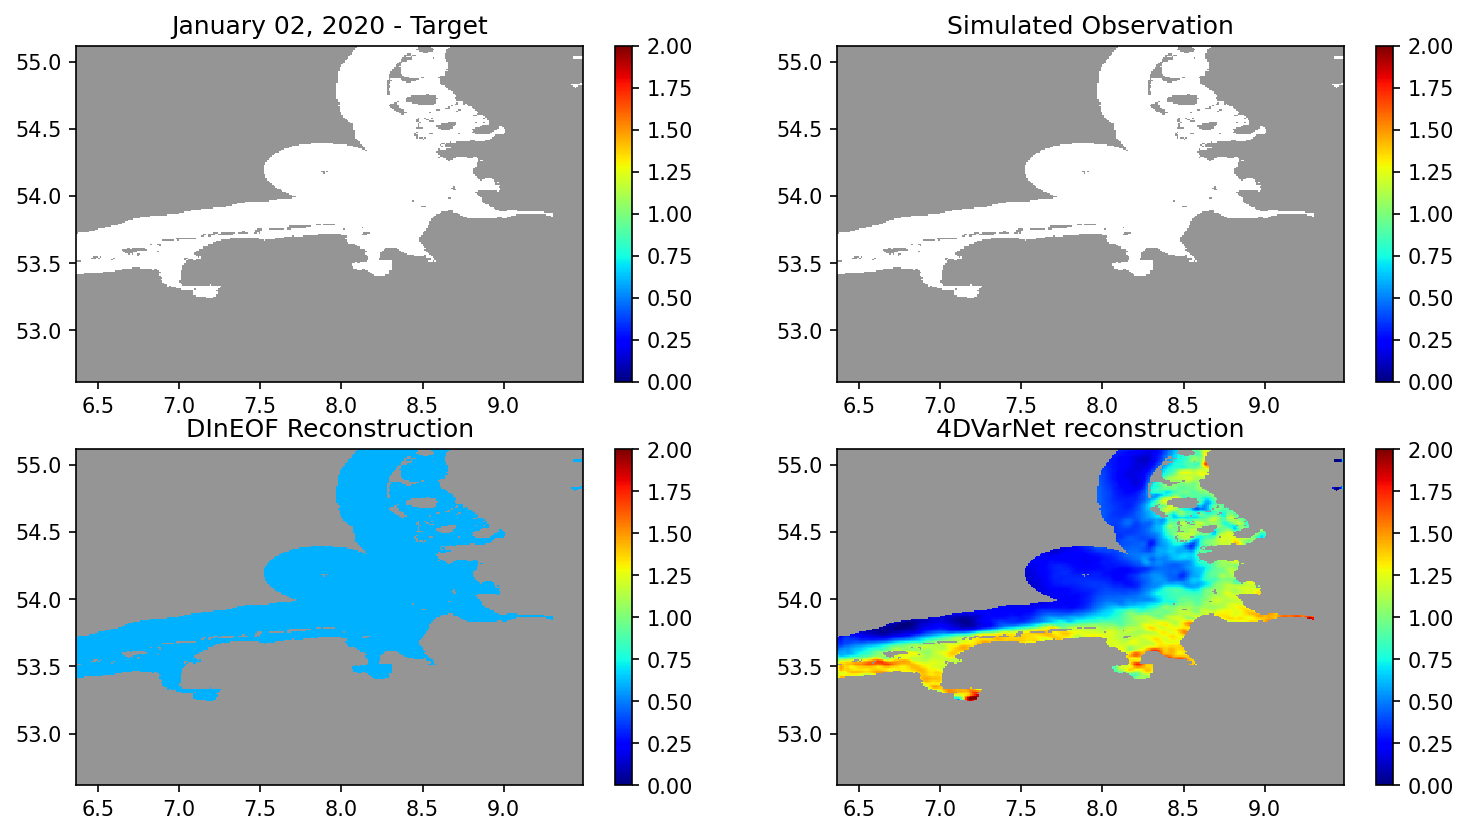

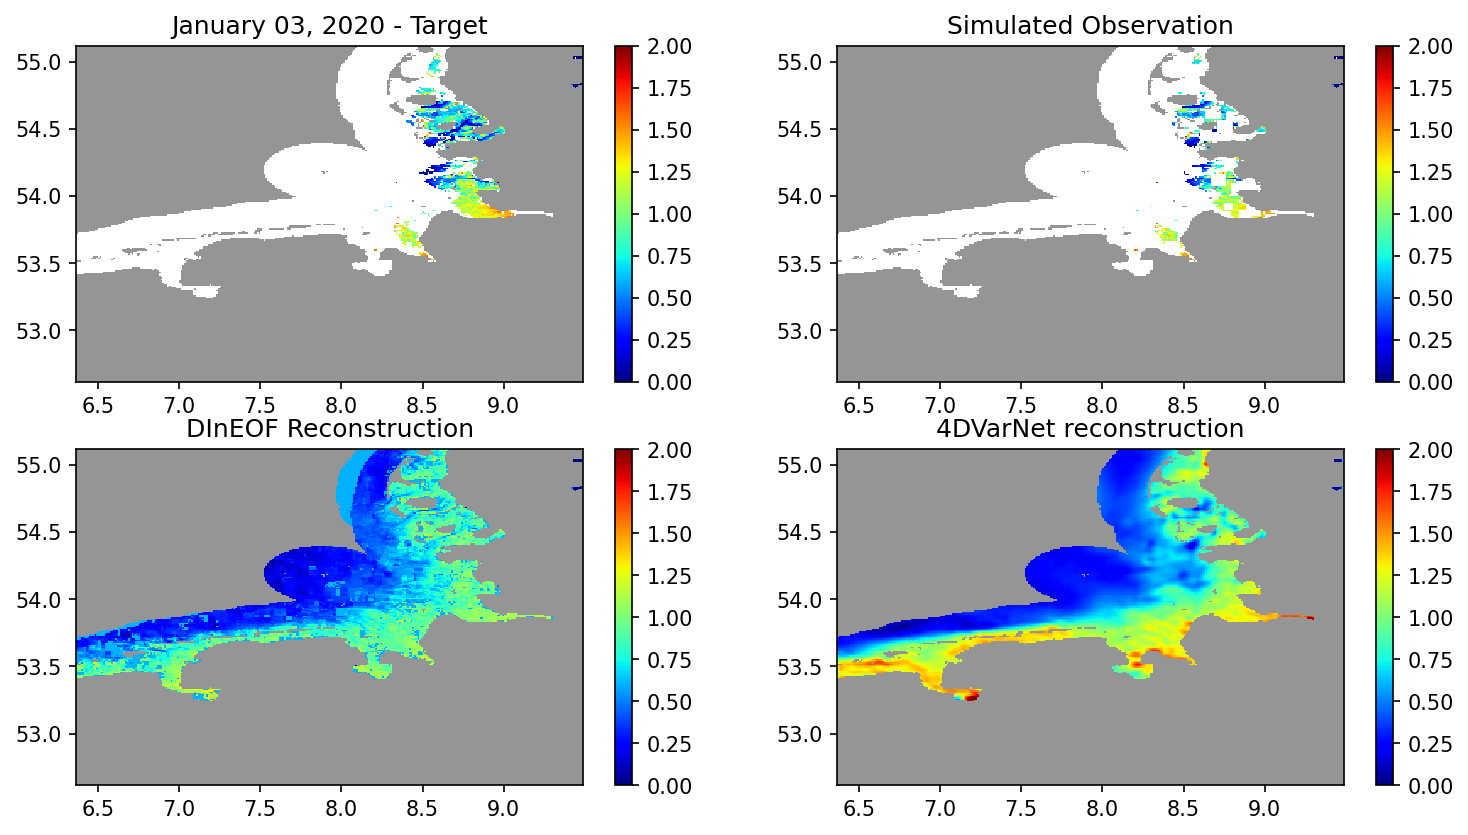

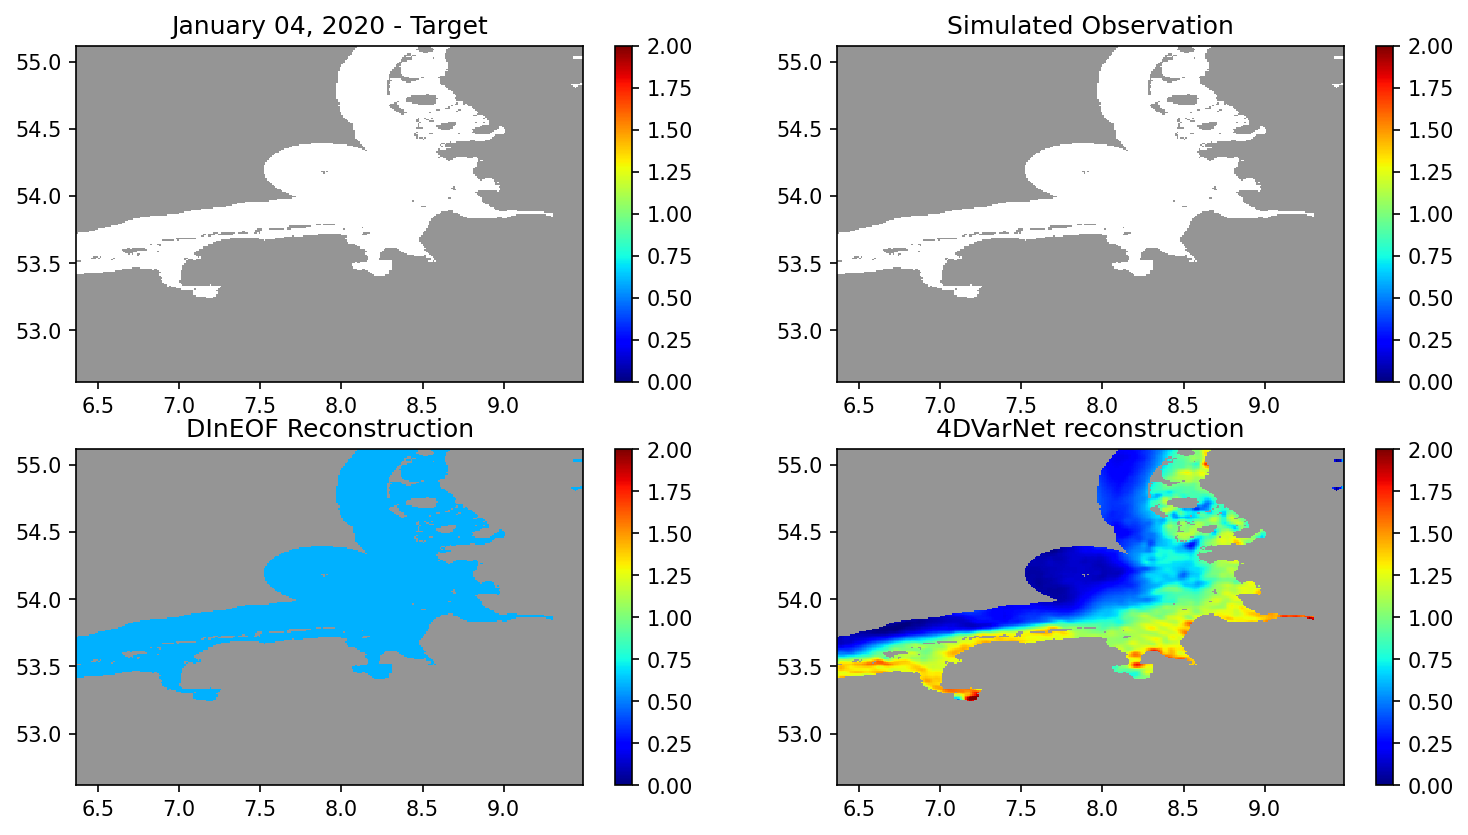

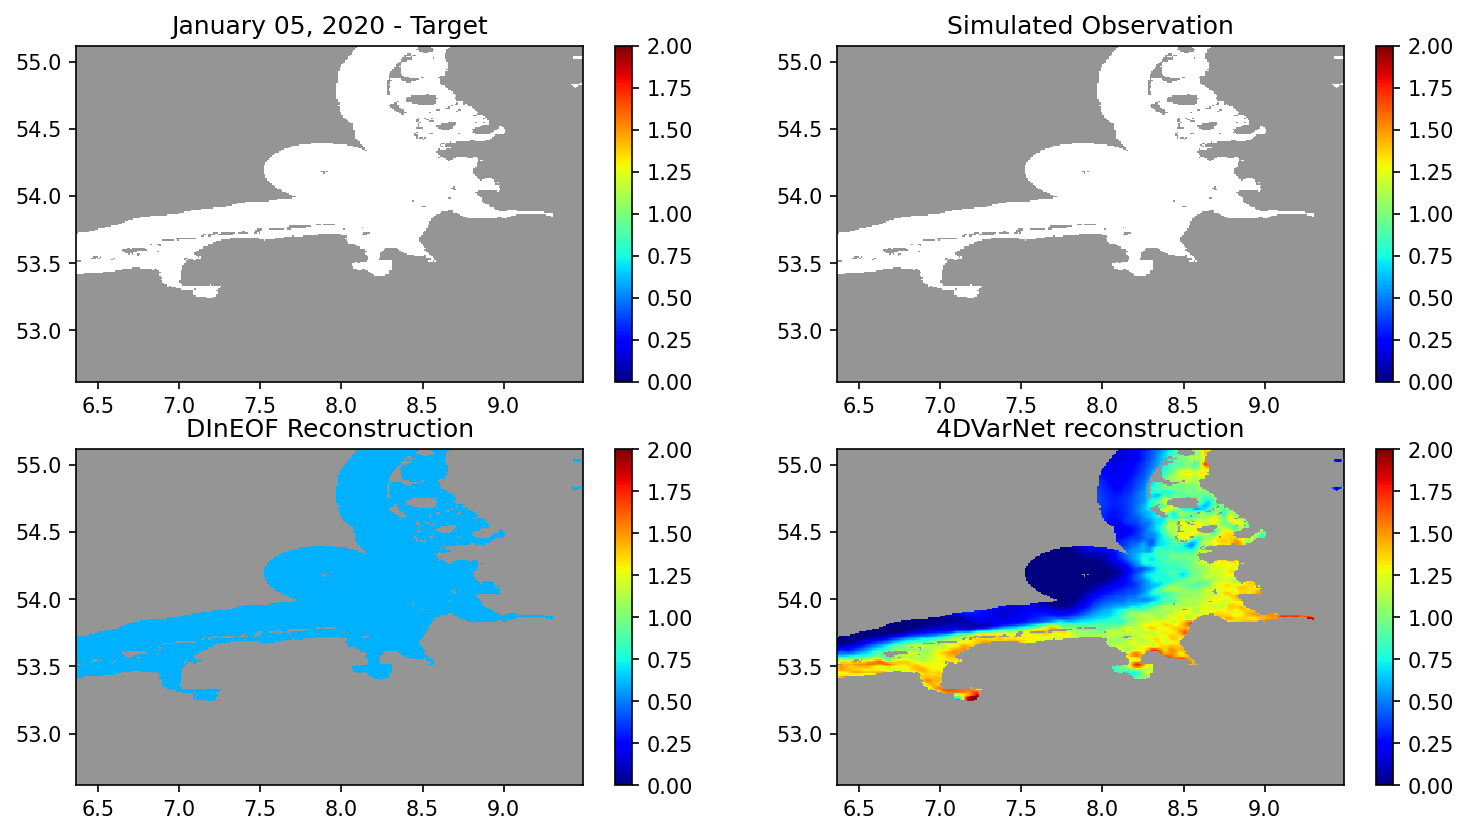

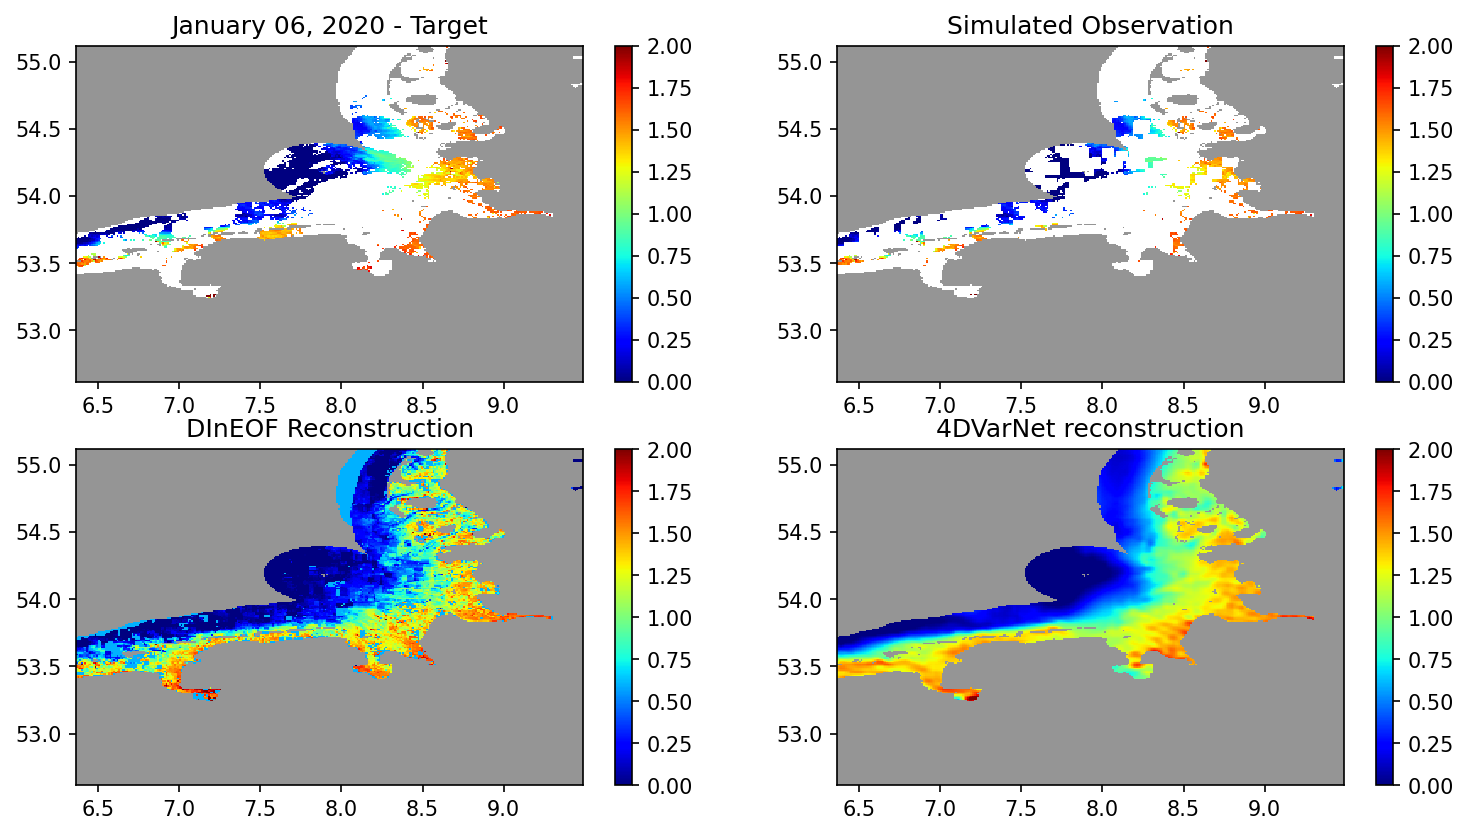

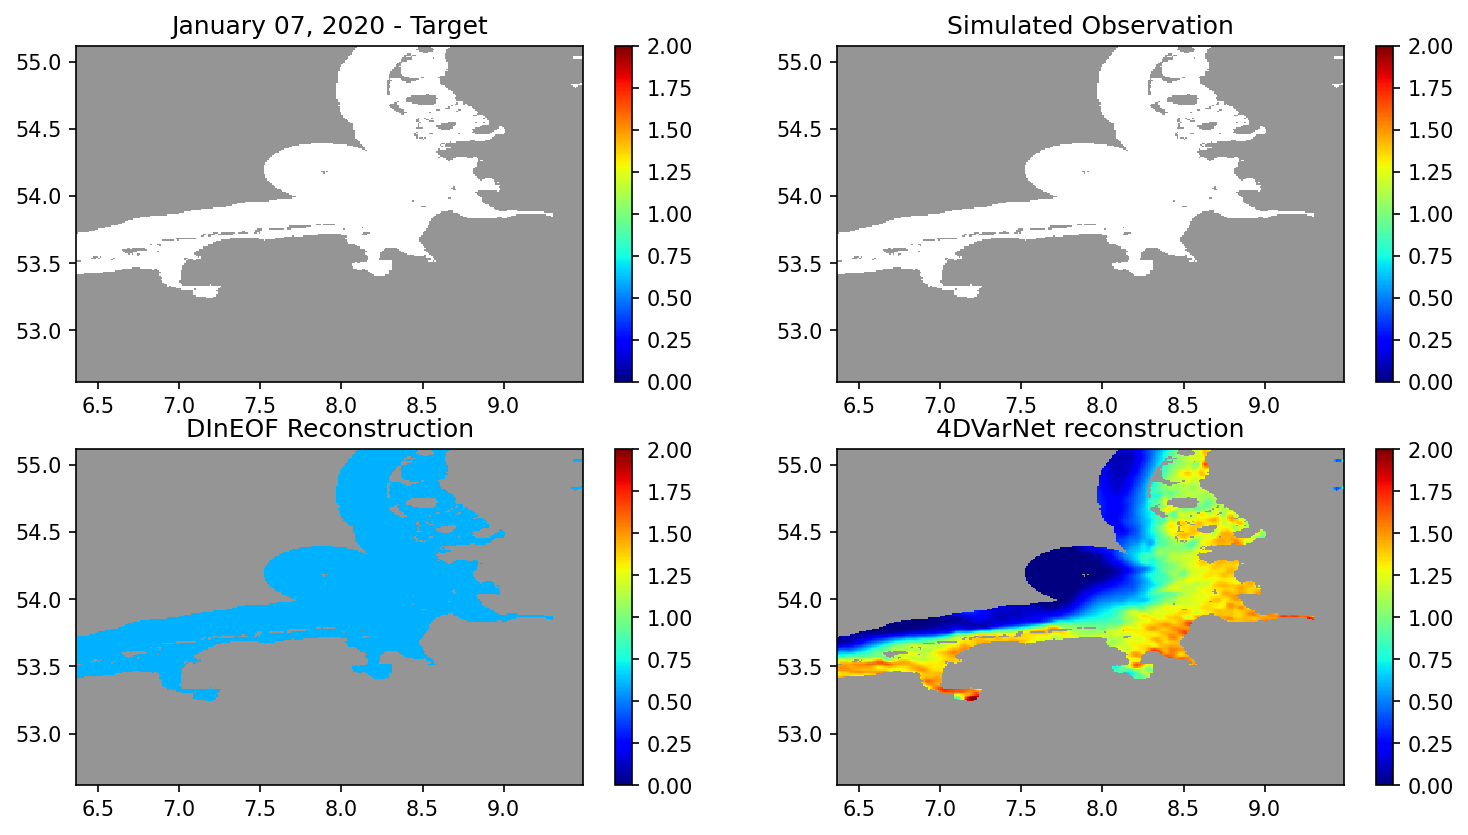

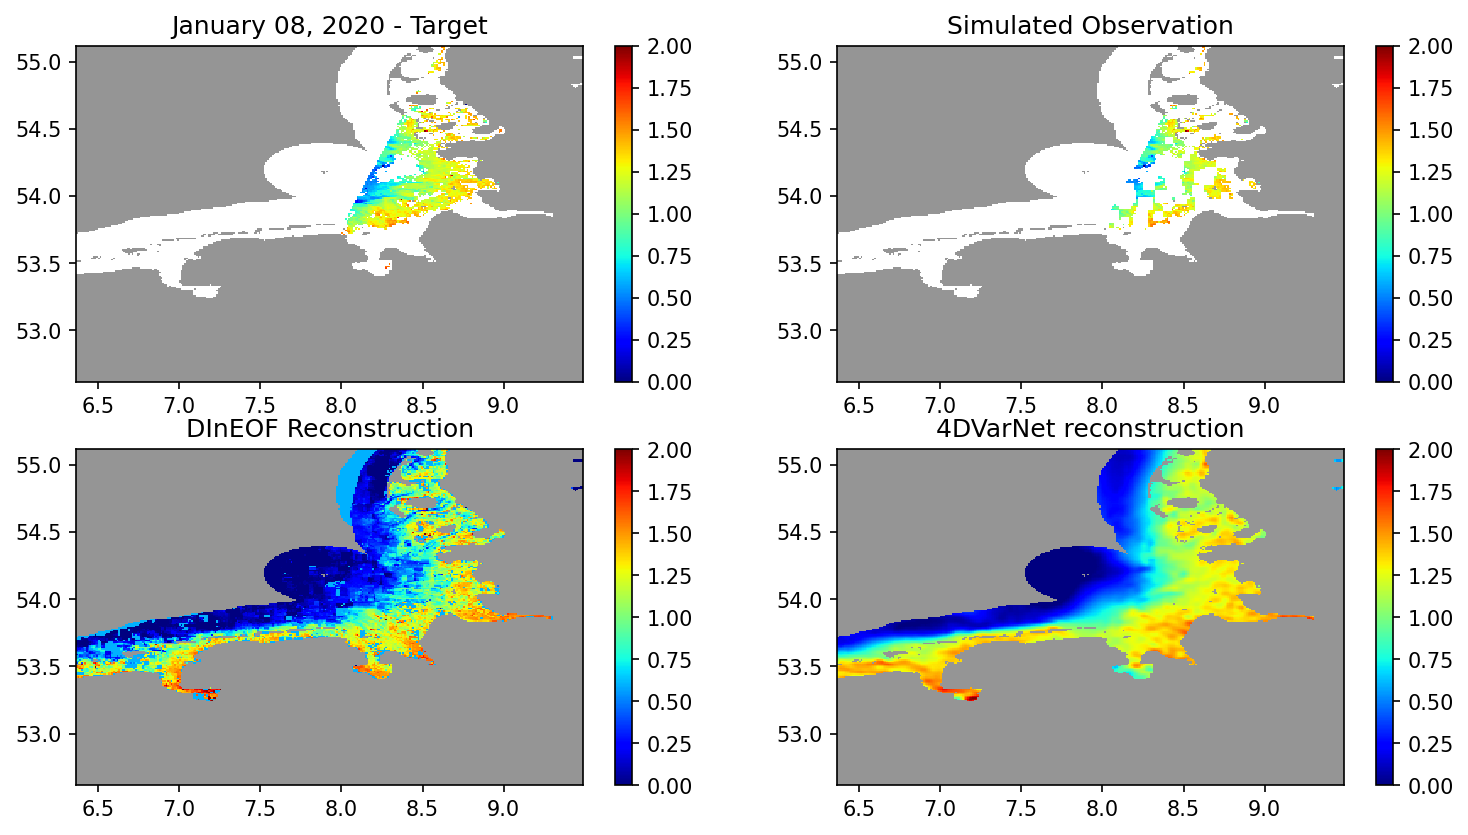

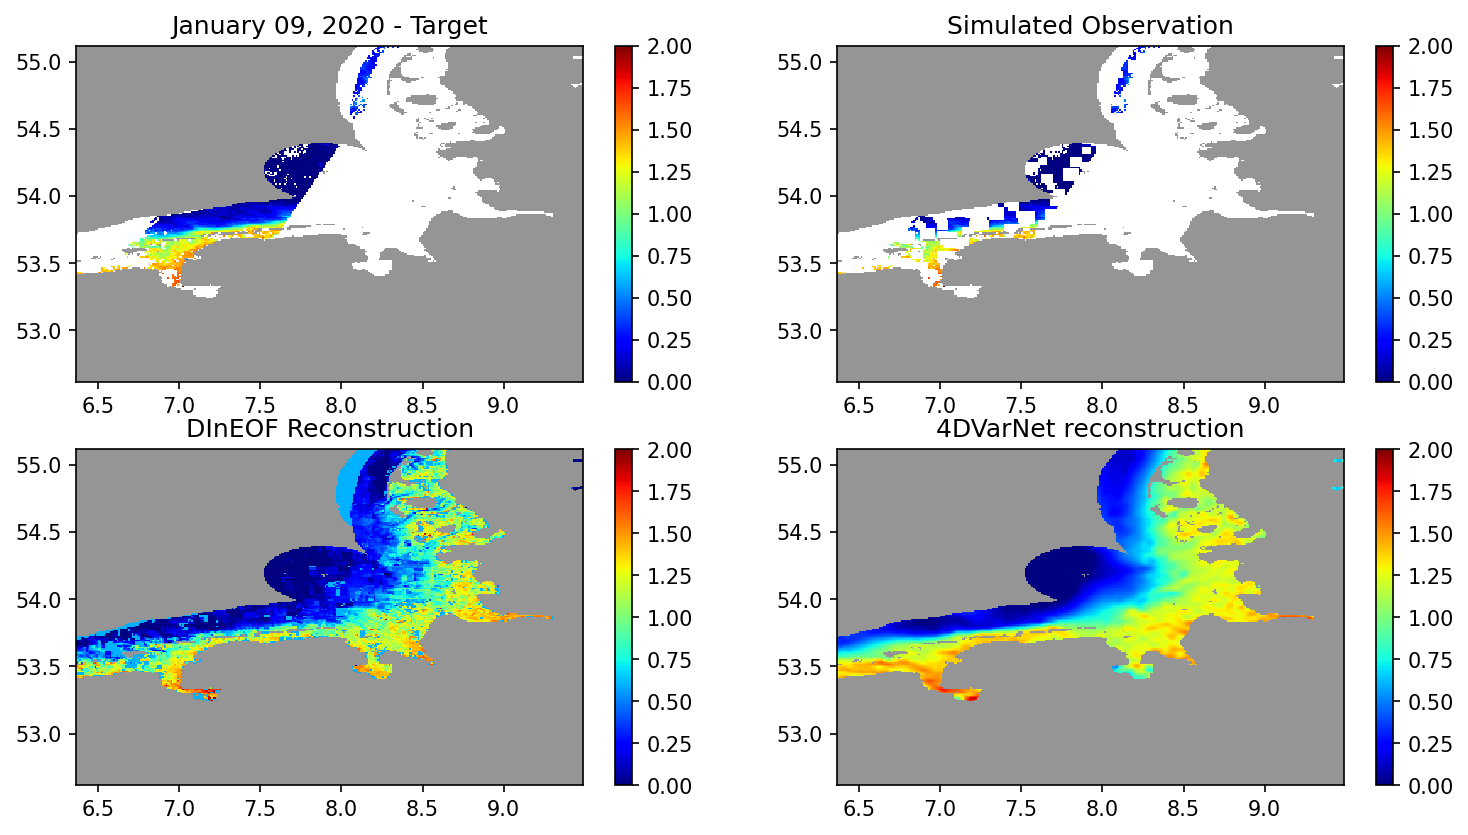

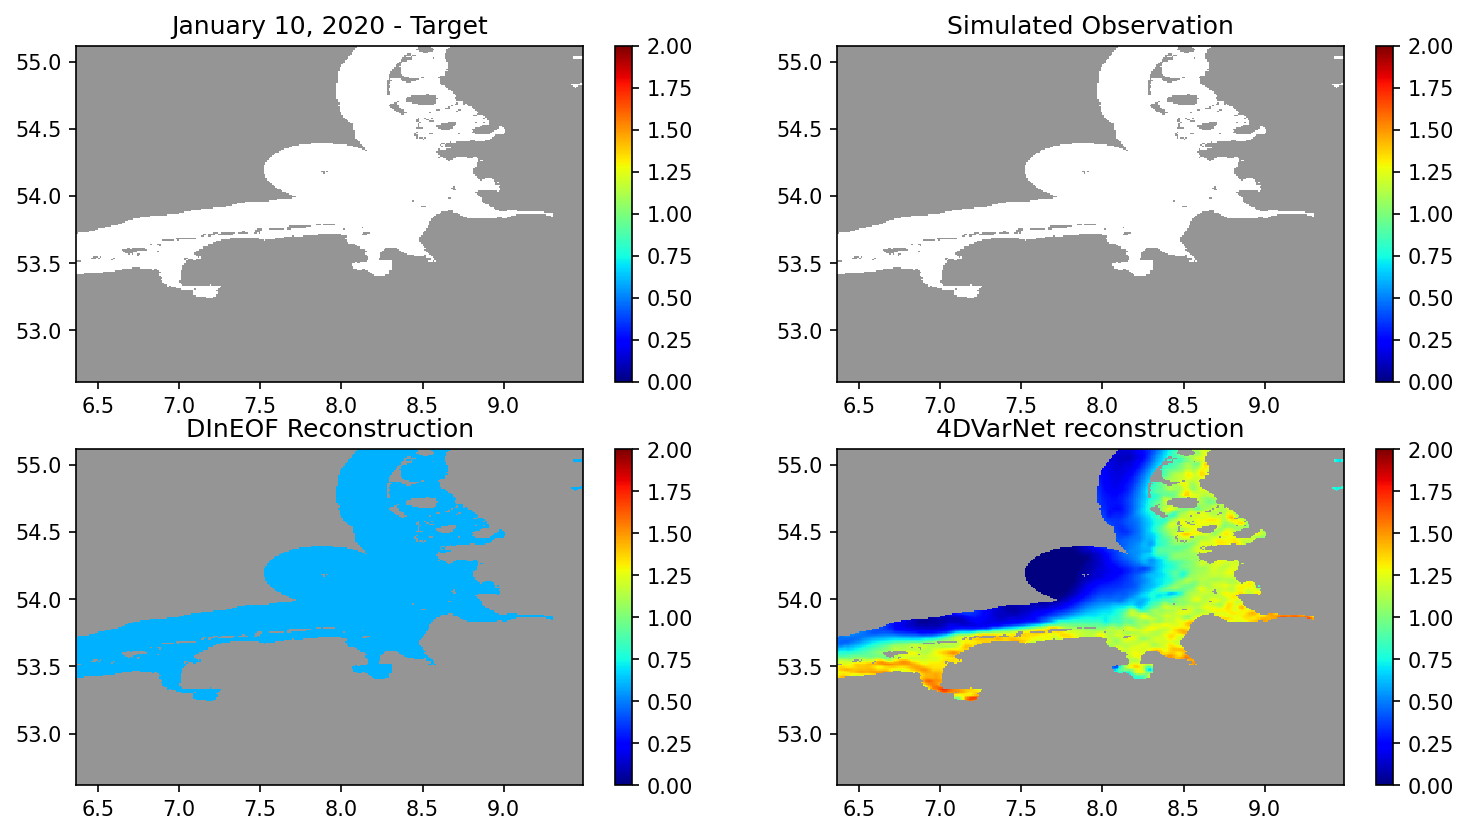

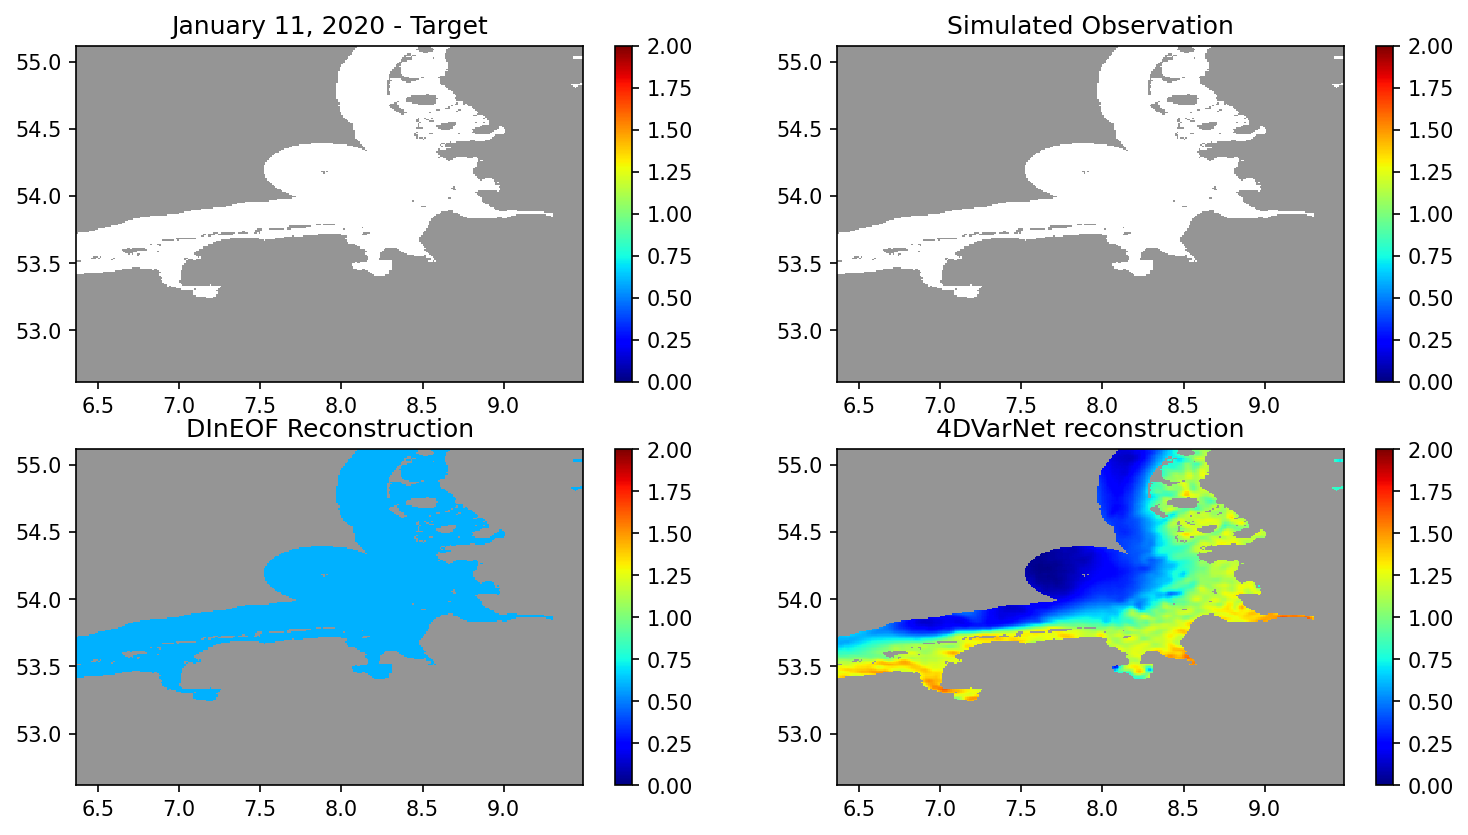

In [32]:
#plot all algorithms
rang_min=1#220,130
rang_max=rang_min+10
step=1

lon = GT.lon
lat = GT.lat

nlat=lat.size
nlon=lon.size

# transpose land_mask
land_mask_transposed = land_mask.transpose('lat', 'lon')


v_min=0.0#np.min(data.tgt[rang_min:rang_max:10])
v_max=2.0#np.max(data.tgt[rang_min:rang_max:10])

for t in range(rang_min,rang_max,step):
    fig, axes = plt.subplots(2, 2, figsize=[2*(4+2), 2*4*(nlat/nlon)])  # Adjust the figsize as needed

    # First subplot (Top left)
    mappable0 = axes[0, 0].pcolormesh(lon, lat, data4DVarnet.tgt[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[0, 0].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax = 2)
    axes[0, 0].set_title(GT.time[t].dt.strftime("%B %d, %Y").values + " - Target")
    fig.colorbar(mappable0, ax=axes[0, 0])

    # Second subplot (Top right)
    mappable1 = axes[0, 1].pcolormesh(lon, lat, data4DVarnet.inp[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[0, 1].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax = 2)
    axes[0, 1].set_title("Simulated Observation")
    fig.colorbar(mappable1, ax=axes[0, 1])

    #  Third subplot (Bottom left)
    mappable2 = axes[1, 0].pcolormesh(lon, lat, rec_DInEOF.SPM.values[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[1, 0].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax = 2)
    axes[1, 0].set_title( "DInEOF Reconstruction")
    fig.colorbar(mappable0, ax=axes[1, 0])

    # Fourth subplot (Bottom right)
    mappable3 = axes[1, 1].pcolormesh(lon, lat, data4DVarnet.out[t], cmap='jet', vmin=v_min, vmax=v_max)
    axes[1, 1].pcolormesh(lon, lat, land_mask.mask, cmap='Greys', vmin=0, vmax = 2)
    axes[1, 1].set_title("4DVarNet reconstruction")
    fig.colorbar(mappable1, ax=axes[1, 1])

    plt.show()  # Display the plot
